In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as snb
import tensorflow as tf
from tensorflow import keras
from scipy import stats as st
from scipy.signal  import resample

c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\pveso\anaconda3\envs\ai_dev\lib\site-packages\tensorflow\pyth

In [3]:
# Returns wether PC os is linux or other
def isLinux():
    return os.name == 'posix'

In [4]:
def saveJson(status, number, data):
    filename = f"C:\\Users\\pveso\\Documents\\heart_attack_analysis\\data\\JSON\\Rhod\\{status}_{number}.json"
    file = open(filename, 'w') 
    file.write(data) 
    file.close() 

In [25]:
 # Salvando os dados em Json formato
import json

def parseNumpyToJson(data, potential, type:str, number:int):
    jsonList = []
    sum = 0
    for j in range(data.shape[0]):
        c = data[j]
        v = potential[j]

        jsonList.append(json.dumps({'V': str(v), 'I': str(c)}, indent=2))
        sum += 1
        
    print(f"Lines Json: {sum}")

    jsonObject = json.dumps({'readings': jsonList})
    saveJson(type, number, jsonObject)

In [6]:
biosense_readings_path = ''
emstast_readings_path = ''

if isLinux():
    pass
else:
    biosense_readings_path = 'C:\\Users\\pveso\\Downloads\\Biosense_Validation\\Commertial_Electrodes_Biosense\\'
    emstast_readings_path = 'C:\\Users\\pveso\\Downloads\\Biosense_Validation\\Commertial_Electrodes_Emstat_Blue\\Readings\\'

In [7]:
# reading all csv files
readings_list = sorted(os.listdir(biosense_readings_path))
df_list_rhodamine = []
df_list_virgin = []
if (len(readings_list) > 0):
    for i in range(len(readings_list)):
        file = readings_list[i]
        df = pd.read_csv(biosense_readings_path + file)
        if ('data_R' in file):
            df_list_rhodamine.append(df)
        else:
            df_list_virgin.append(df)

    print(f'reading pandas df successifully\nRhodamine:{len(df_list_rhodamine)}\nVirgin:{len(df_list_virgin)}')
else:
    print('There is no file in the path')   

reading pandas df successifully
Rhodamine:25
Virgin:25


In [8]:
# Baixando os dados do Emstat Blue
emstat_listfiles = os.listdir(emstast_readings_path)

In [9]:
emstat_virgin_df_list = []
emstat_rhodamine_df_list = []


if (len(emstat_listfiles) > 0):
    print("There are readings in this path")
    for i in range(len(emstat_listfiles)):
        file = emstat_listfiles[i]
        print(file)
        
        if ('.csv' in file):
            df = pd.read_csv(emstast_readings_path + file, sep=';')
            df_aux = df.copy()
            
            for j in range(df.shape[0]):
                for k in range(df.shape[1]):
                    
                    v = df.iloc[j,k]
                    if (isinstance(v, str)):
                        v = v.replace(',','.')
                        if ('.' in v):
                            a = float(v)
                            df_aux.iloc[j,k] = a
                    else:
                        df_aux.iloc[j,k] = float(a)
                        
            if ('R' in file):
                emstat_rhodamine_df_list.append(df_aux)
            else:
                emstat_virgin_df_list.append(df_aux)
else:
    print("There are no readings in this path")
    
print(f'Virging electrodes: {len(emstat_virgin_df_list)}')
print(f'RCN - Electrodes: {len(emstat_rhodamine_df_list)}')

There are readings in this path
E1.csv
E2.csv
E3.csv
E4.csv
E5.csv
R1.csv
R2.csv
R3.csv
R4.csv
R5.csv
Virging electrodes: 5
RCN - Electrodes: 5


In [13]:
# Joining all pandas files into groups with rhodamine and no-rhodamin
emstat_rhodamine = pd.concat(emstat_rhodamine_df_list, axis=1)
emstat_virgin = pd.concat(emstat_virgin_df_list, axis=1)

In [14]:
emstat_potential_rhodamine = emstat_rhodamine.iloc[:,6]
emstat_currents_rhodamine = emstat_rhodamine.iloc[:,1::2]
emstat_potential_virgin = emstat_virgin.iloc[:,6]
emstat_currents_virgin = emstat_virgin.iloc[:,1::2]

In [15]:
emstat_currents_rhodamine = emstat_currents_rhodamine.astype(float)
emstat_currents_virgin = emstat_currents_virgin.astype(float)
emstat_potential_rhodamine = emstat_potential_rhodamine.astype(float)
emstat_potential_virgin = emstat_potential_virgin.astype(float)

In [16]:
# Joining all pandas files into groups with rhodamine and no-rhodamin
biosense_rhodamine = pd.concat(df_list_rhodamine, axis=1)
biosense_virgin = pd.concat(df_list_virgin, axis=1)
potential_rhodamine = biosense_rhodamine.iloc[:,0]
currents_rhodamine = biosense_rhodamine.iloc[:,1::2]
potential_virgin = biosense_virgin.iloc[:,0]
currents_virgin = biosense_virgin.iloc[:,1::2]

In [17]:
diff = abs(emstat_rhodamine.shape[0] - biosense_rhodamine.shape[0])
print(diff)

86


In [18]:
if (diff != 0):
    n_of_samples = 0
    # Emstat reading a greater
    if (emstat_rhodamine.shape[0] > biosense_rhodamine.shape[0]):
        # Take of diff in shape of emstat readings
        n_of_samples = emstat_rhodamine.shape[0] - diff
        emstat_currents_rhodamine_r = resample(emstat_currents_rhodamine, n_of_samples, domain='time')
        emstat_currents_virgin_r = resample(emstat_currents_virgin, n_of_samples, domain='time')
        emstat_potential_virgin_r = resample(emstat_potential_rhodamine, n_of_samples, domain='time')
        emstat_potential_rhodamine_r = resample(emstat_potential_rhodamine, n_of_samples, domain='time')
    else:
        # Take of diff in shape of biosense readings
        pass

In [19]:
print(emstat_currents_virgin_r.shape)
print(emstat_currents_rhodamine_r.shape)
print(currents_rhodamine.shape)
print(currents_virgin.shape)
print(emstat_potential_rhodamine_r.shape)
print(emstat_potential_virgin_r.shape)

(1115, 25)
(1115, 25)
(1115, 25)
(1115, 25)
(1115,)
(1115,)


In [26]:
virgin_1 = currents_virgin.values[:,0]
p_virgin = potential_virgin.values
rhodamine_r = currents_rhodamine.values[:,0]
p_rhod = potential_rhodamine.values

parseNumpyToJson(virgin_1, p_virgin, "neg", 1)
parseNumpyToJson(rhodamine_r, p_rhod, "pos", 1)

Lines Json: 1115
Lines Json: 1115


In [61]:
# Rhodamine = 1
# Virgin = 0

Y = np.concatenate((np.zeros(shape = (1, currents_virgin.shape[1])), np.ones(shape = (1, currents_rhodamine.shape[1]))), axis = 1)
#Y = np.concatenate((np.zeros(shape = (1, currents_virgin.shape[1])), np.ones(shape = (1, currents_rhodamine.shape[1])), np.zeros(shape = (1, emstat_currents_virgin.shape[1])), np.ones(shape = (1, emstat_currents_rhodamine.shape[1]))), axis = 1)
Y = Y.transpose()
Y.shape

(50, 1)

In [62]:
#X = np.concatenate((currents_virgin, currents_rhodamine, emstat_currents_virgin, emstat_currents_rhodamine), axis = 1)
X = np.concatenate((currents_virgin, currents_rhodamine), axis = 1)
X = X.transpose()
X.shape

(50, 1115)

In [17]:
# normalization min-max
for i in range(len(X)):
    values = X[i,:]
    min_ = np.min(values)
    max_ = np.max(values)
    X[i,:] = (values - min_) / (max_ - min_)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33, 1115)
(33, 1)
(17, 1115)
(17, 1)


In [19]:
model = tf.keras.Sequential()

# First convolutional layer
model.add(tf.keras.layers.Conv1D(activation='relu', input_shape = (1115, 1), kernel_size=7, filters=8, padding='causal'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
# Second convolutional layer
#model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# Flatten layer to transition from convolutional layers to dense layers
model.add(tf.keras.layers.Flatten())

# Fully connected layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()
          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1115, 8)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 557, 8)            0         
_________________________________________________________________
dropout (Dropout)            (None, 557, 8)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4456)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               570496    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [126]:
model_checkpoint_path = ''
if (isLinux()):
    pass
else:
    model_checkpoint_path = 'C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\CNN_Model'
callback = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1, mode = 'max')

In [127]:
# Reshape the data to fit the 1D CNN input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
batch_size = 5
epochs = 30

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks = [callback])

Train on 33 samples, validate on 17 samples
Epoch 1/30
 5/33 [===>..........................] - ETA: 1s - loss: 0.7441 - acc: 0.2000
Epoch 00001: val_acc improved from -inf to 0.52941, saving model to C:\Users\pveso\Documents\heart_attack_analysis\src\CNN_Model
33/33 [==============================] - 1s 20ms/sample - loss: 0.6990 - acc: 0.4848 - val_loss: 0.6919 - val_acc: 0.5294
Epoch 2/30
 5/33 [===>..........................] - ETA: 0s - loss: 0.6832 - acc: 0.4000
Epoch 00002: val_acc did not improve from 0.52941
33/33 [==============================] - 0s 2ms/sample - loss: 0.6914 - acc: 0.4848 - val_loss: 0.6897 - val_acc: 0.5294
Epoch 3/30
 5/33 [===>..........................] - ETA: 0s - loss: 0.6748 - acc: 0.8000
Epoch 00003: val_acc did not improve from 0.52941
33/33 [==============================] - 0s 2ms/sample - loss: 0.6922 - acc: 0.4848 - val_loss: 0.6876 - val_acc: 0.5294
Epoch 4/30
 5/33 [===>..........................] - ETA: 0s - loss: 0.6665 - acc: 0.6000
Epoch 0

In [128]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_accuracy = history.history['val_acc']

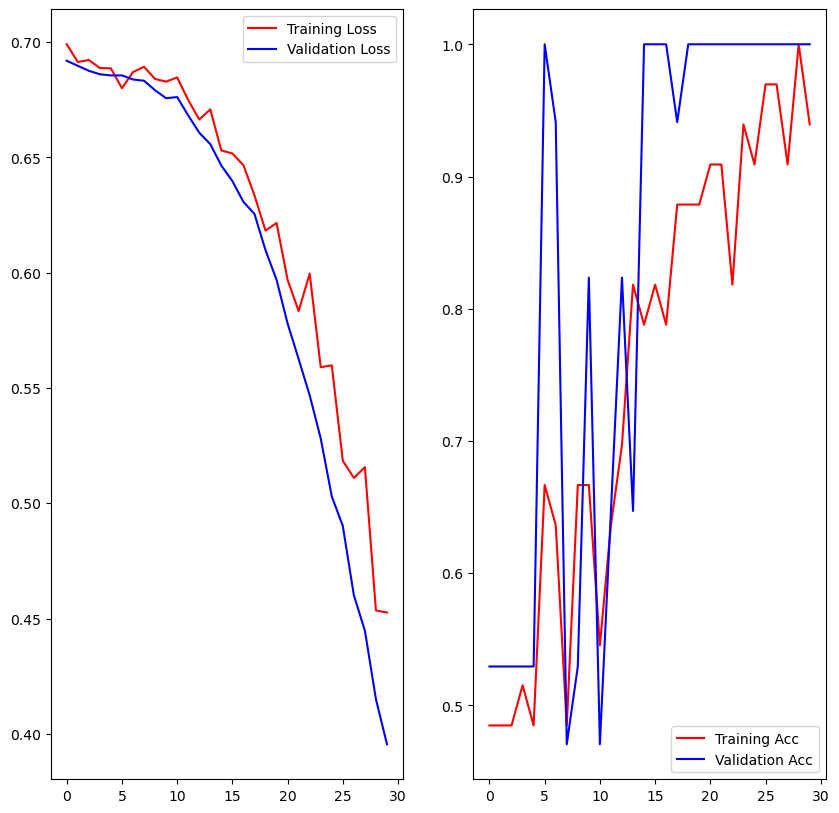

In [129]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,10))
ax0.plot(loss, color = 'r', label = 'Training Loss')
ax0.plot(val_loss, color = 'b', label = 'Validation Loss')
ax1.plot(acc, color = 'r', label = 'Training Acc')
ax1.plot(val_accuracy, color = 'b', label = 'Validation Acc')
ax1.legend()
ax0.legend()
plt.show()


In [130]:
# Matriz confusão
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc
model.load_weights(model_checkpoint_path)
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
cm = confusion_matrix(y_test, y_pred)

In [131]:
#Save the model to a file
model.save("C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\Rhod\\cnn_rod.h5")

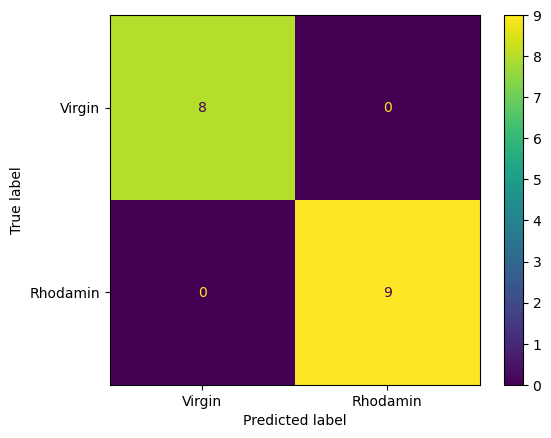

In [132]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Virgin', 'Rhodamin']).plot()

In [133]:
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

1.0
1.0


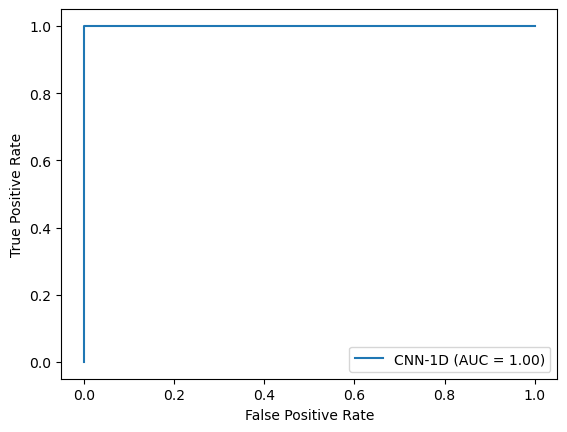

In [134]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CNN-1D')
display.plot()
plt.show()

Text(0, 0.5, 'Current (uA)')

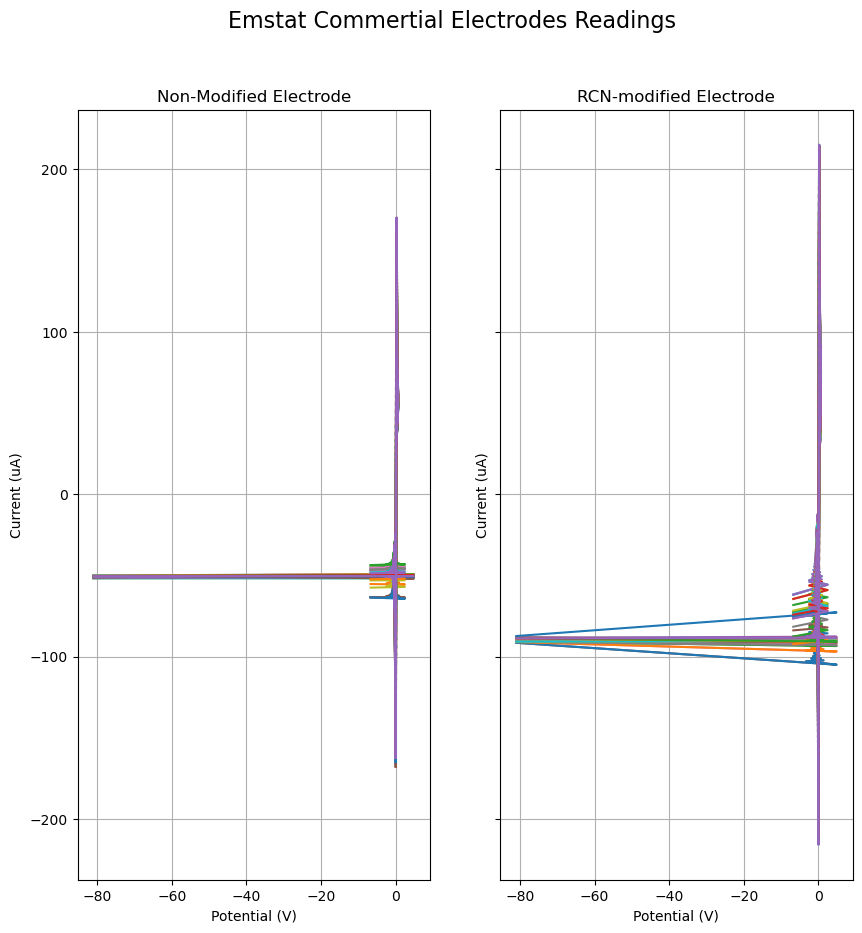

In [20]:
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle('Emstat Commertial Electrodes Readings', fontsize=16)
for i in range(emstat_currents_virgin_r.shape[1]):
    ax0.plot(emstat_potential_virgin_r, emstat_currents_virgin_r[:,i])
    
for i in range(emstat_currents_rhodamine_r.shape[1]):
    ax1.plot(emstat_potential_rhodamine_r, emstat_currents_rhodamine_r[:,i])

ax0.grid()
ax1.grid()
ax0.title.set_text('Non-Modified Electrode')
ax1.title.set_text('RCN-modified Electrode')
# Set common labels
ax0.set_xlabel('Potential (V)')
ax0.set_ylabel('Current (uA)')
ax1.set_xlabel('Potential (V)')
ax1.set_ylabel('Current (uA)')

In [21]:
Y_sanity = np.concatenate((np.zeros(shape = (1, emstat_currents_virgin_r.shape[1])), np.ones(shape = (1, emstat_currents_rhodamine_r.shape[1]))), axis = 1)
Y_sanity = Y_sanity.transpose()
Y_sanity.shape

(50, 1)

In [22]:
X_sanity = np.concatenate((emstat_currents_virgin_r, emstat_currents_rhodamine_r), axis = 1)
X_sanity = X_sanity.transpose()

In [23]:
single_sample = X_sanity[0]
reshaped_sample = single_sample.reshape(-1, 1)
reshaped_sample.shape

(1115, 1)

In [24]:
copy = reshaped_sample.copy()

max_ = np.max(copy)
min_ = np.min(copy)
copy[:,0] = ((copy[:,0] - min_) / (max_ - min_))

In [39]:
from Hep.inference_rhod import Rhod
inference_module = Rhod("C:\\Users\\pveso\\Documents\\heart_attack_analysis\\src\\Hep\\Models\\Rhod\\cnn_rod.h5")
single_sample = X_sanity[10]


In [40]:
normalized_single_sample = inference_module.normalize(single_sample.reshape(-1,1))

In [41]:
inference_module.predict_sample(single_sample.reshape(-1,1))

0

In [42]:
print(single_sample.max())
print(normalized_single_sample.max())

164.1313143725797
1.0


In [31]:
# normalization min-max
for i in range(len(X_sanity)):
    values = X_sanity[i,:]
    min_ = np.min(values)
    max_ = np.max(values)
    X_sanity[i,:] = (values - min_) / (max_ - min_)

In [32]:
X_sanity.shape

(50, 1115)

In [34]:
y_pred = model.predict(X_sanity.reshape(X_sanity.shape[0], X_sanity.shape[1], 1))
y_pred = y_pred > 0.5
cm = confusion_matrix(Y_sanity, y_pred, labels=[0, 1])

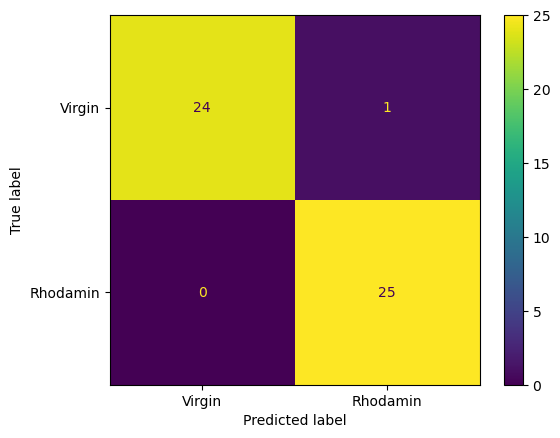

In [35]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Virgin', 'Rhodamin']).plot()

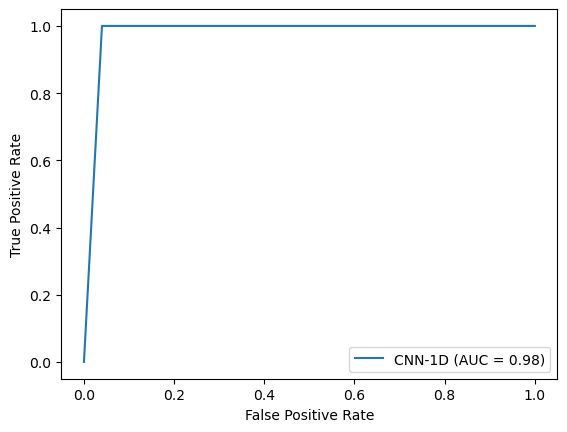

In [36]:
fpr, tpr, thresholds = roc_curve(Y_sanity, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='CNN-1D')
display.plot()
plt.show()